#### Importing Python Libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Configuration

In [2]:
start_date = "2016-01-01"
end_date   = "2026-01-01"
forecast_days = 365  # Forecast horizon in days
weekly_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

#### Stock 1 [AAPL]

##### Downloading Data

In [3]:
df_aapl_raw = yf.download(
    "AAPL", 
    start=start_date, 
    end=end_date, 
    auto_adjust=True, 
    progress=False
)

df_aapl_raw.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2016-01-04,23.753155,23.757665,22.997834,23.135370,270597600
2016-01-05,23.157915,23.865887,23.090275,23.843341,223164000
2016-01-06,22.704721,23.081256,22.517584,22.673156,273829600
2016-01-07,21.746485,22.576211,21.741976,22.249281,324377600
2016-01-08,21.861469,22.346228,21.816376,22.219966,283192000


##### Handling MultiIndex if exists

In [4]:
if isinstance(df_aapl_raw.columns, pd.MultiIndex):
    df_aapl_raw.columns = df_aapl_raw.columns.droplevel('Ticker')

df_aapl_raw.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2016-01-04,23.753155,23.757665,22.997834,23.135370,270597600
2016-01-05,23.157915,23.865887,23.090275,23.843341,223164000
2016-01-06,22.704721,23.081256,22.517584,22.673156,273829600
2016-01-07,21.746485,22.576211,21.741976,22.249281,324377600
2016-01-08,21.861469,22.346228,21.816376,22.219966,283192000


In [5]:
df_aapl_raw.reset_index(inplace=True)
df_aapl_raw.head()

Price,Date,Close,High,Low,Open,Volume
0,2016-01-04,23.753155,23.757665,22.997834,23.135370,270597600
1,2016-01-05,23.157915,23.865887,23.090275,23.843341,223164000
2,2016-01-06,22.704721,23.081256,22.517584,22.673156,273829600
3,2016-01-07,21.746485,22.576211,21.741976,22.249281,324377600
4,2016-01-08,21.861469,22.346228,21.816376,22.219966,283192000


##### Preparing Data for Prophet

In [6]:
df_aapl = df_aapl_raw[['Date','Close']].rename(columns={'Date':'ds','Close':'y'})
df_aapl.head()

Price,ds,y
0,2016-01-04,23.753155
1,2016-01-05,23.157915
2,2016-01-06,22.704721
3,2016-01-07,21.746485
4,2016-01-08,21.861469


##### Fitting the Prophet Model

In [7]:
model_aapl = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=True, 
    daily_seasonality=True
)

model_aapl.fit(df_aapl)

15:16:59 - cmdstanpy - INFO - Chain [1] start processing
15:17:00 - cmdstanpy - INFO - Chain [1] done processing


##### Creating Future Dataframe

In [8]:
future_aapl = model_aapl.make_future_dataframe(periods=forecast_days, freq='D')
future_aapl.tail()

,ds
2874,2026-12-27
2875,2026-12-28
2876,2026-12-29
2877,2026-12-30
2878,2026-12-31


##### Making Forecast

In [9]:
forecast_aapl = model_aapl.predict(future_aapl)
forecast_aapl[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2874,2026-12-27,289.560598,268.372717,308.418449
2875,2026-12-28,289.374612,269.542153,307.195130
2876,2026-12-29,289.108076,267.336930,309.256323
2877,2026-12-30,288.800634,268.361291,306.560617
2878,2026-12-31,288.447666,267.594437,307.098988


##### Plotting Actual vs Forecasting

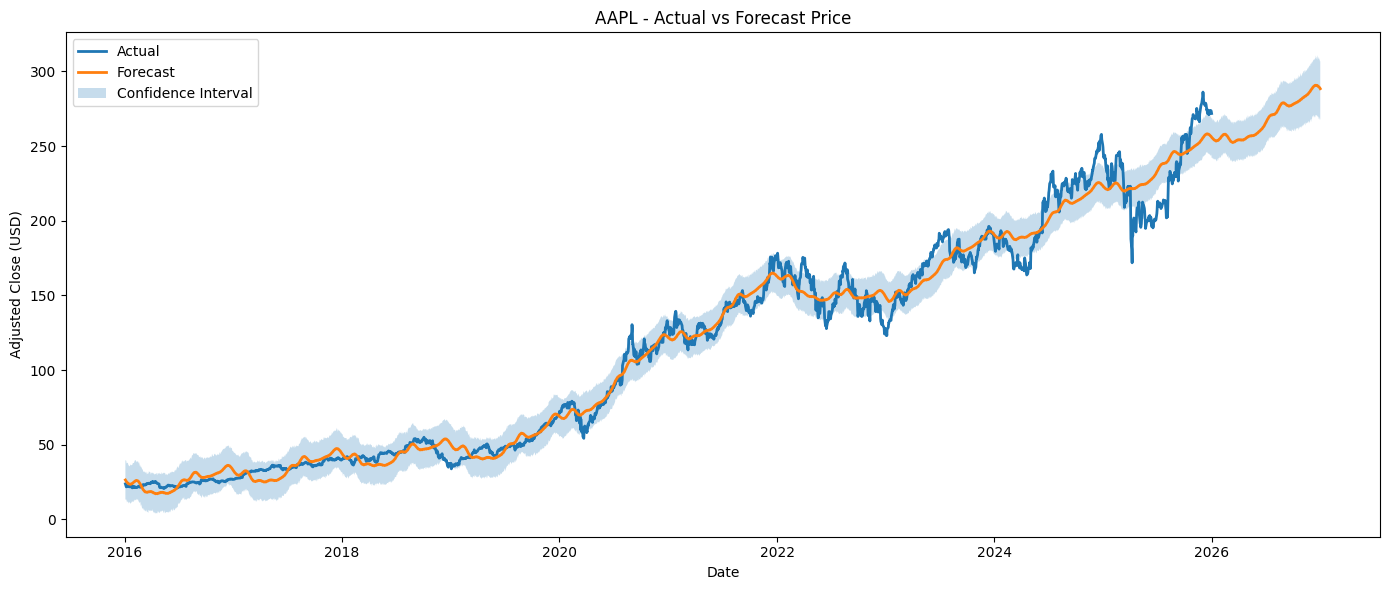

In [10]:
plt.figure(figsize=(14,6))
sns.lineplot(data=df_aapl, x='ds', y='y', label='Actual', linewidth=2)
sns.lineplot(data=forecast_aapl, x='ds', y='yhat', label='Forecast', linewidth=2)
plt.fill_between(
    forecast_aapl['ds'],
    forecast_aapl['yhat_lower'],
    forecast_aapl['yhat_upper'],
    alpha=0.25,
    label='Confidence Interval'
)
plt.title("AAPL - Actual vs Forecast Price")
plt.xlabel("Date")
plt.ylabel("Adjusted Close (USD)")
plt.legend()
plt.tight_layout()
plt.show()

##### Plotting the Trend Component

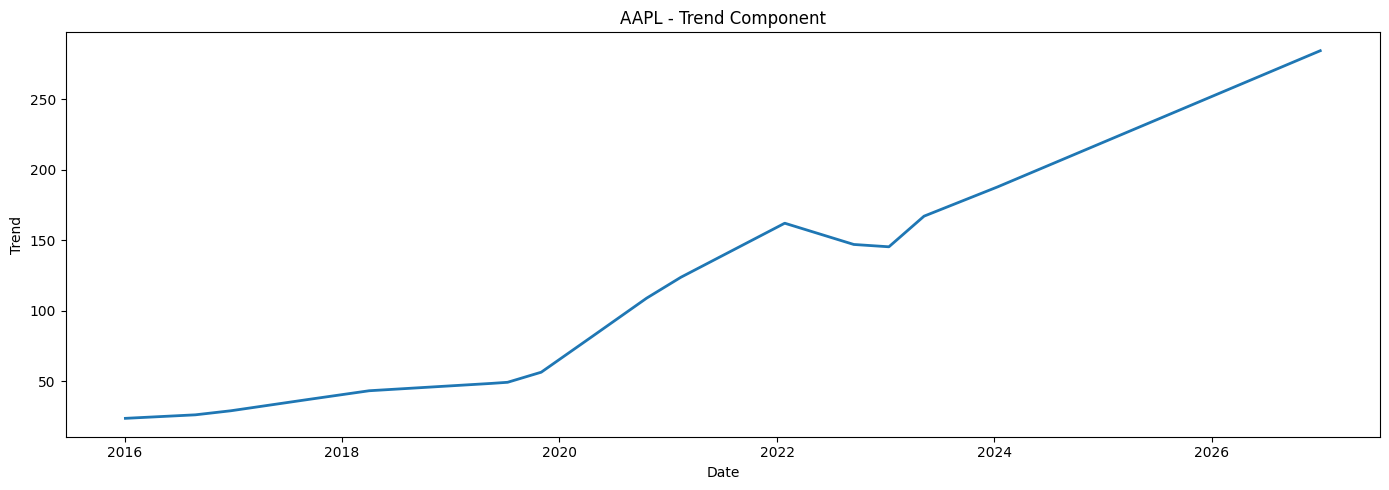

In [11]:
plt.figure(figsize=(14,5))
sns.lineplot(data=forecast_aapl, x='ds', y='trend', linewidth=2)
plt.title("AAPL - Trend Component")
plt.xlabel("Date")
plt.ylabel("Trend")
plt.tight_layout()
plt.show()

##### Plotting Yearly Seasonality

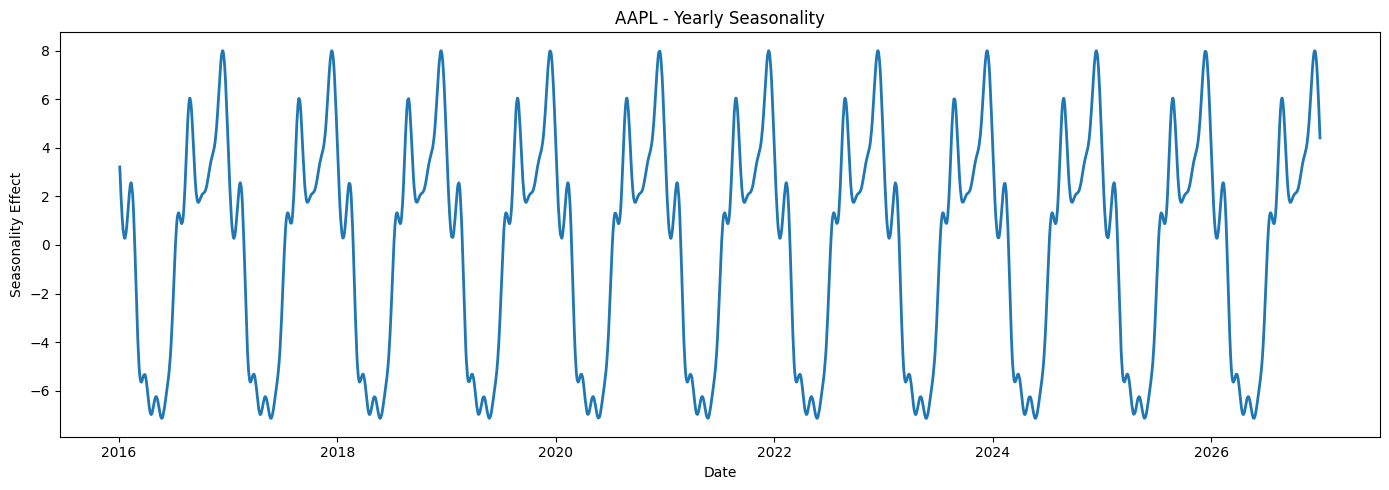

In [12]:
plt.figure(figsize=(14,5))
sns.lineplot(data=forecast_aapl, x='ds', y='yearly', linewidth=2)
plt.title("AAPL - Yearly Seasonality")
plt.xlabel("Date")
plt.ylabel("Seasonality Effect")
plt.tight_layout()
plt.show()

##### Plotting Monthly Component

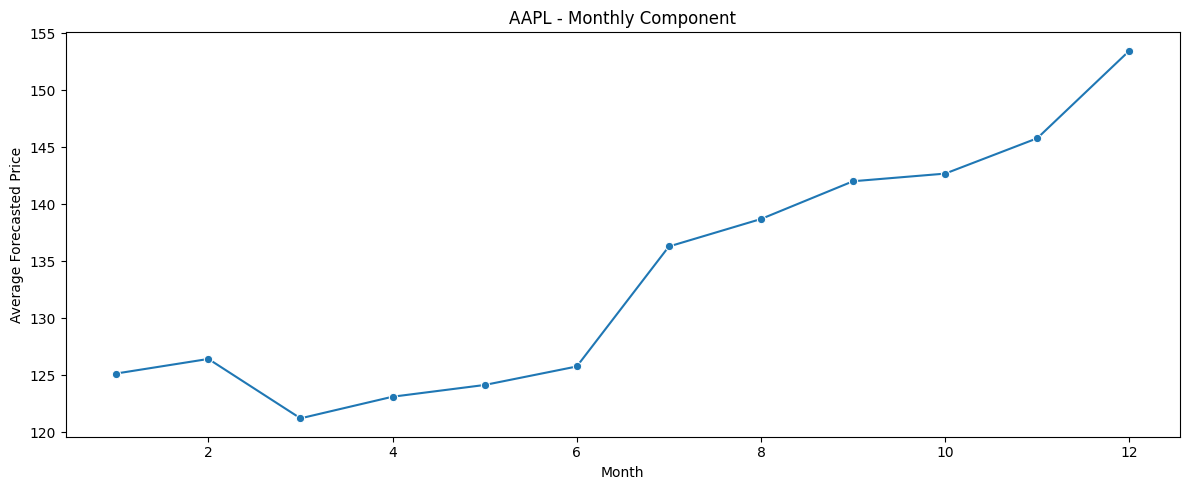

In [13]:
forecast_aapl['month'] = forecast_aapl['ds'].dt.month
monthly_aapl = forecast_aapl.groupby('month')['yhat'].mean().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_aapl, x='month', y='yhat', marker='o')
plt.title("AAPL - Monthly Component")
plt.xlabel("Month")
plt.ylabel("Average Forecasted Price")
plt.tight_layout()
plt.show()

##### Plotting Weekly Component

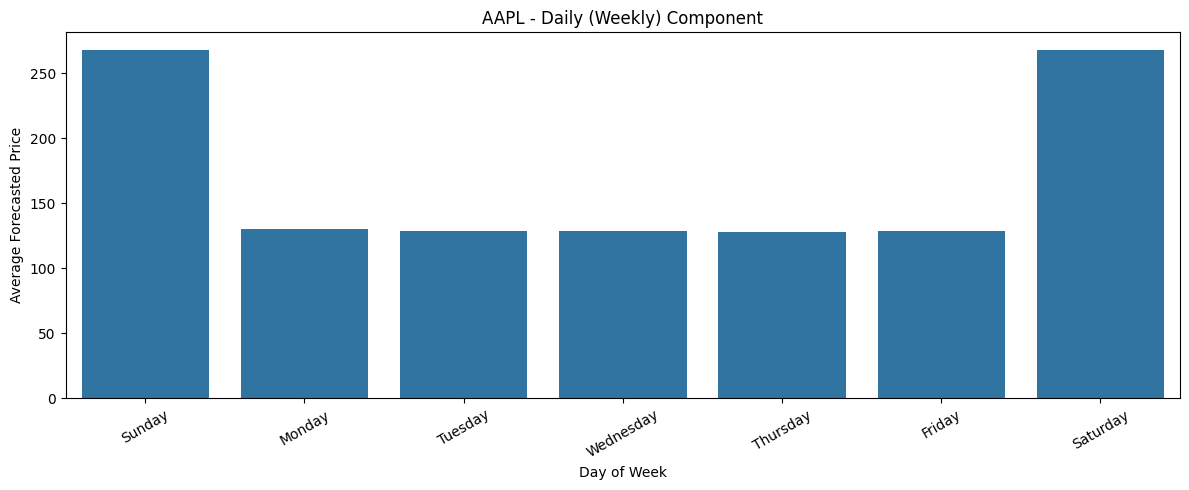

In [14]:
forecast_aapl['weekday'] = forecast_aapl['ds'].dt.day_name()
weekly_aapl = forecast_aapl.groupby('weekday')['yhat'].mean().reindex(weekly_order).reset_index()

plt.figure(figsize=(12,5))
sns.barplot(data=weekly_aapl, x='weekday', y='yhat')
plt.title("AAPL - Daily (Weekly) Component")
plt.xlabel("Day of Week")
plt.ylabel("Average Forecasted Price")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

#### Stock 2 [MSFT]

##### Downloading Data

In [15]:
df_msft_raw = yf.download(
    "MSFT", 
    start=start_date, 
    end=end_date, 
    auto_adjust=True, 
    progress=False
)

df_msft_raw.head()

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2016-01-04,47.983456,47.983456,46.748845,47.563163,53778000
2016-01-05,48.202370,48.500077,47.755810,48.097297,34079700
2016-01-06,47.326748,47.633214,46.967748,47.563163,39518900
2016-01-07,45.680603,46.836412,45.593043,46.144679,56564900
2016-01-08,45.820694,46.652521,45.663084,45.855716,48754000


##### Handling MultiIndex if exists

In [16]:
if isinstance(df_msft_raw.columns, pd.MultiIndex):
    df_msft_raw.columns = df_msft_raw.columns.droplevel('Ticker')

df_msft_raw.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2016-01-04,47.983456,47.983456,46.748845,47.563163,53778000
2016-01-05,48.202370,48.500077,47.755810,48.097297,34079700
2016-01-06,47.326748,47.633214,46.967748,47.563163,39518900
2016-01-07,45.680603,46.836412,45.593043,46.144679,56564900
2016-01-08,45.820694,46.652521,45.663084,45.855716,48754000


In [17]:
df_msft_raw.reset_index(inplace=True)
df_msft_raw.head()

Price,Date,Close,High,Low,Open,Volume
0,2016-01-04,47.983456,47.983456,46.748845,47.563163,53778000
1,2016-01-05,48.202370,48.500077,47.755810,48.097297,34079700
2,2016-01-06,47.326748,47.633214,46.967748,47.563163,39518900
3,2016-01-07,45.680603,46.836412,45.593043,46.144679,56564900
4,2016-01-08,45.820694,46.652521,45.663084,45.855716,48754000


##### Preparing Data for Prophet

In [18]:
df_msft = df_msft_raw[['Date','Close']].rename(columns={'Date':'ds','Close':'y'})
df_msft.head()

Price,ds,y
0,2016-01-04,47.983456
1,2016-01-05,48.202370
2,2016-01-06,47.326748
3,2016-01-07,45.680603
4,2016-01-08,45.820694


##### Fitting the Prophet Model

In [19]:
model_msft = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=True, 
    daily_seasonality=True
)

model_msft.fit(df_msft)

15:17:01 - cmdstanpy - INFO - Chain [1] start processing
15:17:02 - cmdstanpy - INFO - Chain [1] done processing


##### Creating Future Dataframe

In [20]:
future_msft = model_msft.make_future_dataframe(periods=forecast_days, freq='D')
future_msft.tail()

,ds
2874,2026-12-27
2875,2026-12-28
2876,2026-12-29
2877,2026-12-30
2878,2026-12-31


##### Making Forecast

In [21]:
forecast_msft = model_msft.predict(future_msft)
forecast_msft[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2874,2026-12-27,553.226397,513.707461,593.019370
2875,2026-12-28,552.919280,511.709721,594.893983
2876,2026-12-29,552.720982,511.321958,592.173882
2877,2026-12-30,552.831422,512.852600,594.408749
2878,2026-12-31,552.682276,510.486006,593.791860


##### Plotting Actual vs Forecasting

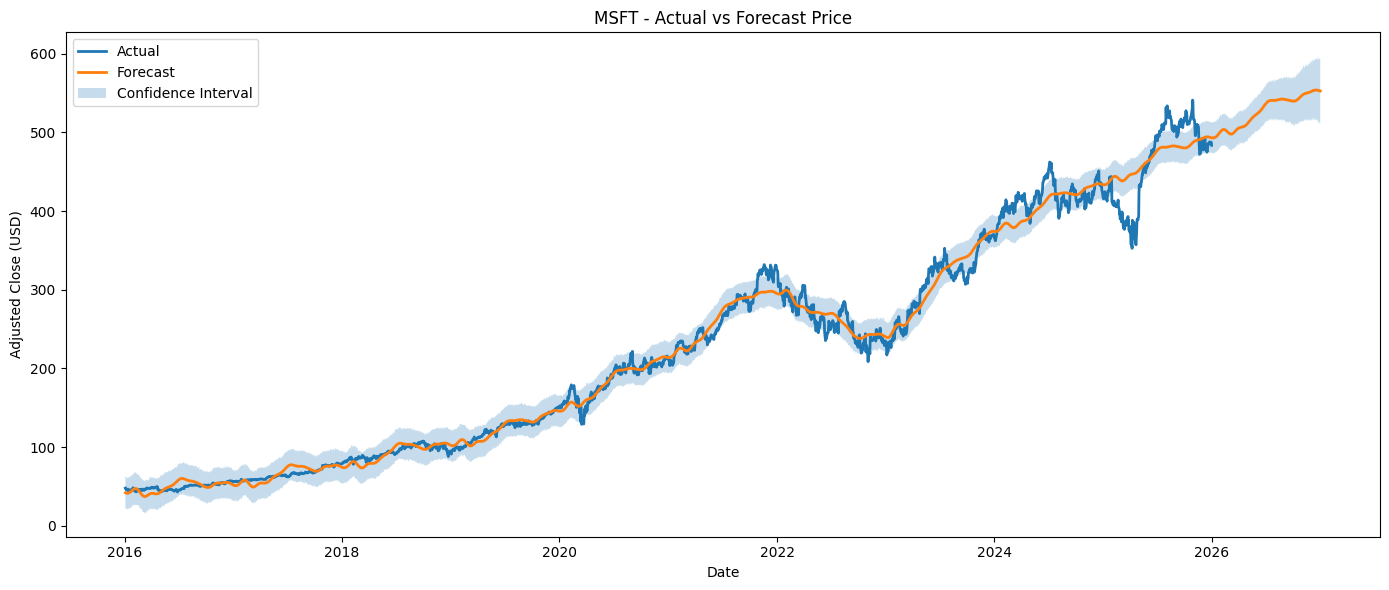

In [22]:
plt.figure(figsize=(14,6))
sns.lineplot(data=df_msft, x='ds', y='y', label='Actual', linewidth=2)
sns.lineplot(data=forecast_msft, x='ds', y='yhat', label='Forecast', linewidth=2)
plt.fill_between(
    forecast_msft['ds'],
    forecast_msft['yhat_lower'],
    forecast_msft['yhat_upper'],
    alpha=0.25,
    label='Confidence Interval'
)
plt.title("MSFT - Actual vs Forecast Price")
plt.xlabel("Date")
plt.ylabel("Adjusted Close (USD)")
plt.legend()
plt.tight_layout()
plt.show()

##### Plotting the Trend Component

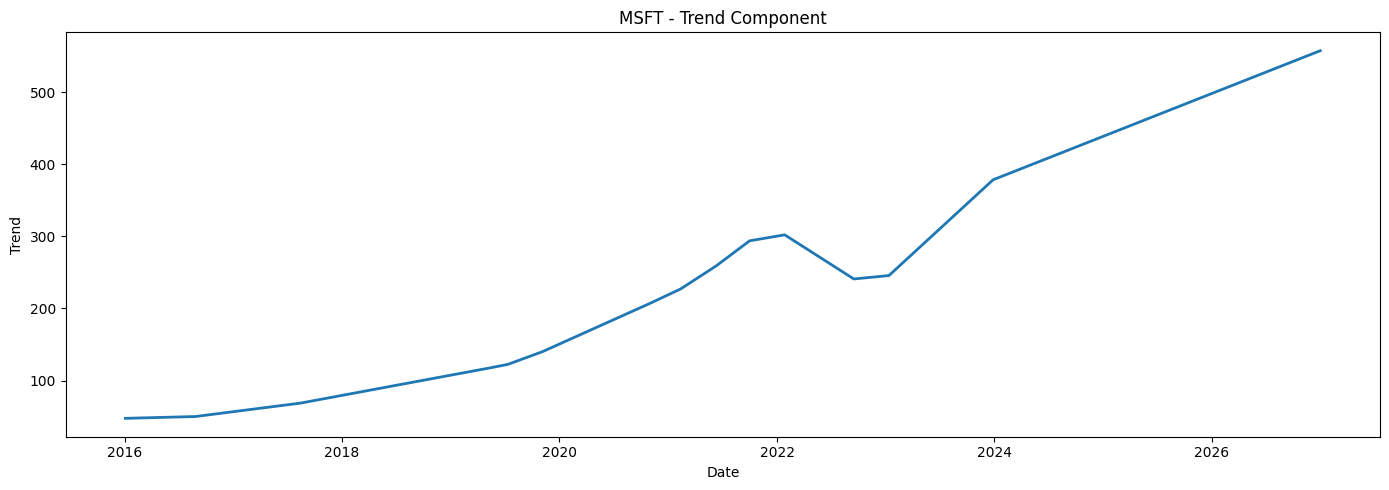

In [23]:
plt.figure(figsize=(14,5))
sns.lineplot(data=forecast_msft, x='ds', y='trend', linewidth=2)
plt.title("MSFT - Trend Component")
plt.xlabel("Date")
plt.ylabel("Trend")
plt.tight_layout()
plt.show()

##### Plotting Yearly Seasonality

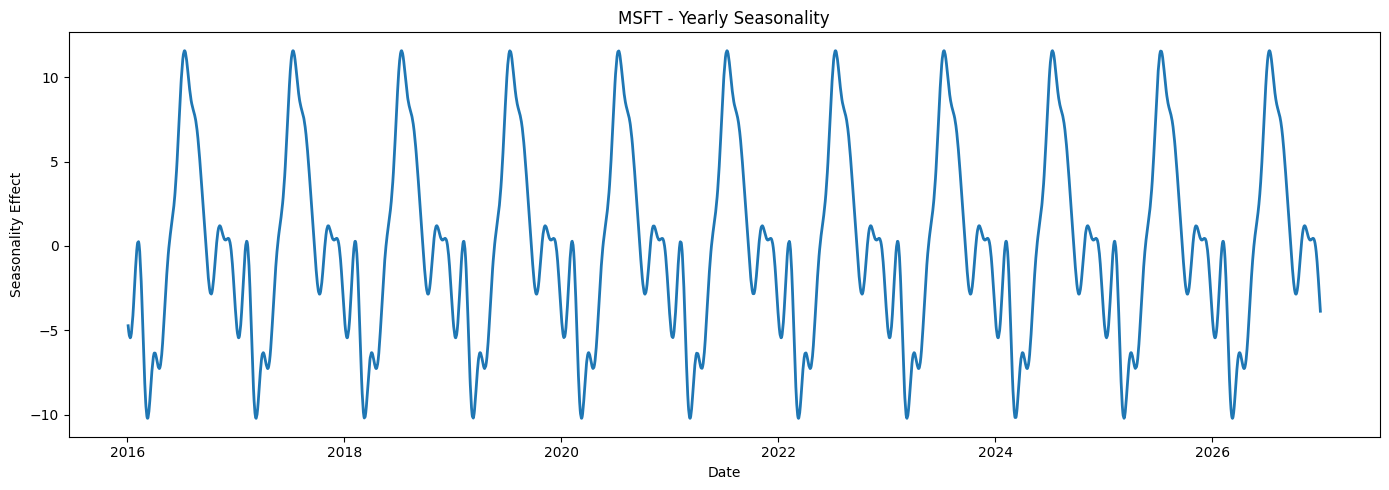

In [24]:
plt.figure(figsize=(14,5))
sns.lineplot(data=forecast_msft, x='ds', y='yearly', linewidth=2)
plt.title("MSFT - Yearly Seasonality")
plt.xlabel("Date")
plt.ylabel("Seasonality Effect")
plt.tight_layout()
plt.show()

##### Plotting Monthly Component

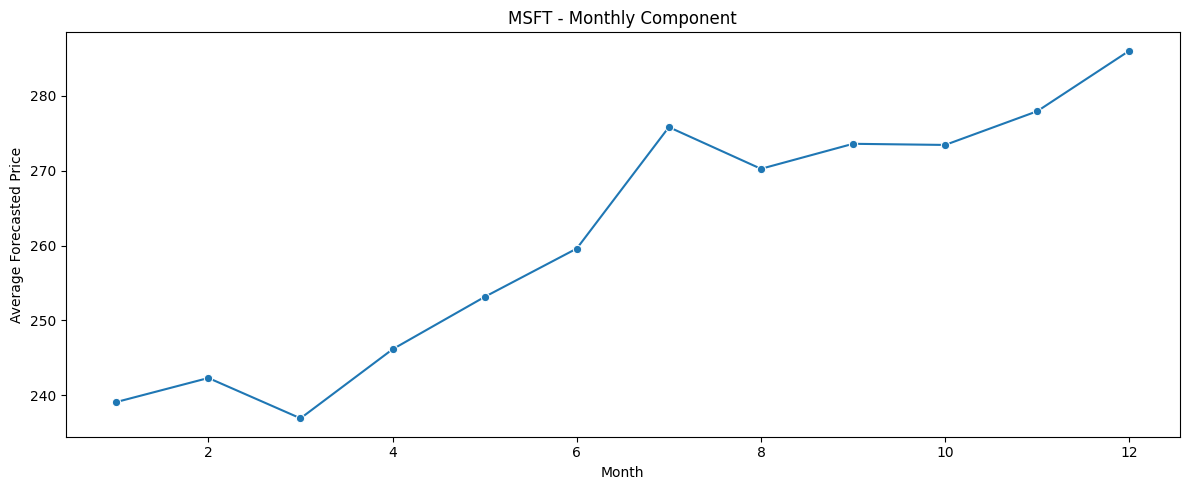

In [25]:
forecast_msft['month'] = forecast_msft['ds'].dt.month
monthly_msft = forecast_msft.groupby('month')['yhat'].mean().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_msft, x='month', y='yhat', marker='o')
plt.title("MSFT - Monthly Component")
plt.xlabel("Month")
plt.ylabel("Average Forecasted Price")
plt.tight_layout()
plt.show()

##### Plotting Weekly Component

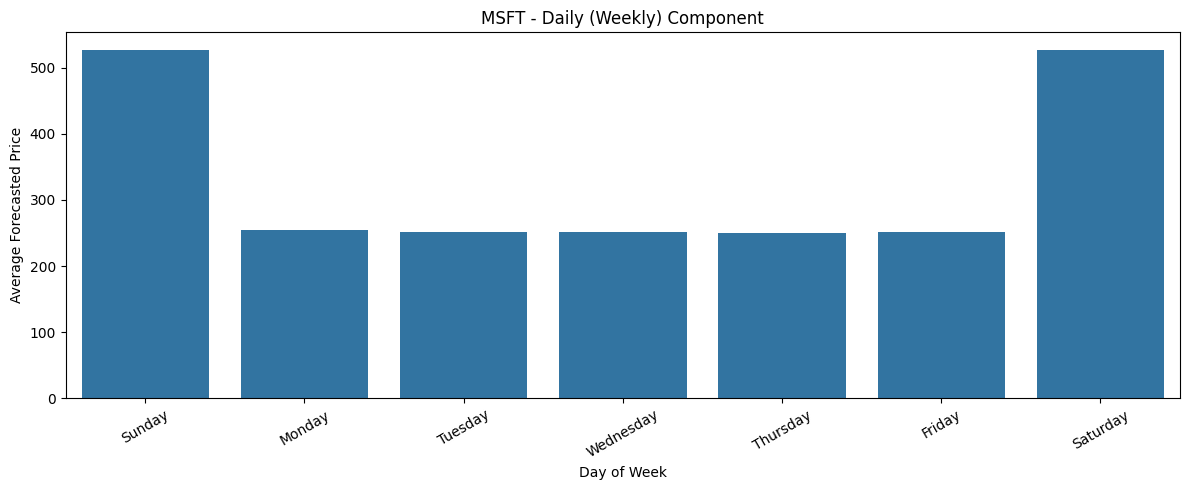

In [26]:
forecast_msft['weekday'] = forecast_msft['ds'].dt.day_name()
weekly_msft = forecast_msft.groupby('weekday')['yhat'].mean().reindex(weekly_order).reset_index()

plt.figure(figsize=(12,5))
sns.barplot(data=weekly_msft, x='weekday', y='yhat')
plt.title("MSFT - Daily (Weekly) Component")
plt.xlabel("Day of Week")
plt.ylabel("Average Forecasted Price")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

#### Stock 3 [GOOGL]

##### Downloading Data

In [27]:
df_googl_raw = yf.download(
    "GOOGL", 
    start=start_date, 
    end=end_date, 
    auto_adjust=True, 
    progress=False
)

df_googl_raw.head()

Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2016-01-04,37.687244,37.824210,37.096705,37.824210,67382000
2016-01-05,37.790958,38.171582,37.499164,37.918497,45216000
2016-01-06,37.681786,37.999386,37.119536,37.237147,48206000
2016-01-07,36.772160,37.482294,36.488305,37.044603,63132000
2016-01-08,36.271442,37.224738,36.172686,37.109607,47506000


##### Handling MultiIndex if exists

In [28]:
if isinstance(df_googl_raw.columns, pd.MultiIndex):
    df_googl_raw.columns = df_googl_raw.columns.droplevel('Ticker')

df_googl_raw.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2016-01-04,37.687244,37.824210,37.096705,37.824210,67382000
2016-01-05,37.790958,38.171582,37.499164,37.918497,45216000
2016-01-06,37.681786,37.999386,37.119536,37.237147,48206000
2016-01-07,36.772160,37.482294,36.488305,37.044603,63132000
2016-01-08,36.271442,37.224738,36.172686,37.109607,47506000


In [29]:
df_googl_raw.reset_index(inplace=True)
df_googl_raw.head()

Price,Date,Close,High,Low,Open,Volume
0,2016-01-04,37.687244,37.824210,37.096705,37.824210,67382000
1,2016-01-05,37.790958,38.171582,37.499164,37.918497,45216000
2,2016-01-06,37.681786,37.999386,37.119536,37.237147,48206000
3,2016-01-07,36.772160,37.482294,36.488305,37.044603,63132000
4,2016-01-08,36.271442,37.224738,36.172686,37.109607,47506000


##### Preparing Data for Prophet

In [30]:
df_googl = df_googl_raw[['Date','Close']].rename(columns={'Date':'ds','Close':'y'})
df_googl.head()

Price,ds,y
0,2016-01-04,37.687244
1,2016-01-05,37.790958
2,2016-01-06,37.681786
3,2016-01-07,36.772160
4,2016-01-08,36.271442


##### Fitting the Prophet Model

In [31]:
model_googl = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=True, 
    daily_seasonality=True
)

model_googl.fit(df_googl)

15:17:03 - cmdstanpy - INFO - Chain [1] start processing
15:17:03 - cmdstanpy - INFO - Chain [1] done processing


##### Creating Future Dataframe

In [32]:
future_googl = model_googl.make_future_dataframe(periods=forecast_days, freq='D')
future_googl.tail()

,ds
2874,2026-12-27
2875,2026-12-28
2876,2026-12-29
2877,2026-12-30
2878,2026-12-31


##### Making Forecast

In [33]:
forecast_googl = model_googl.predict(future_googl)
forecast_googl[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2874,2026-12-27,298.410146,274.578222,321.034129
2875,2026-12-28,298.015413,272.879947,323.189624
2876,2026-12-29,297.729023,273.437589,321.290584
2877,2026-12-30,297.532827,274.558496,320.470933
2878,2026-12-31,296.927450,271.771113,318.824448


##### Plotting Actual vs Forecasting

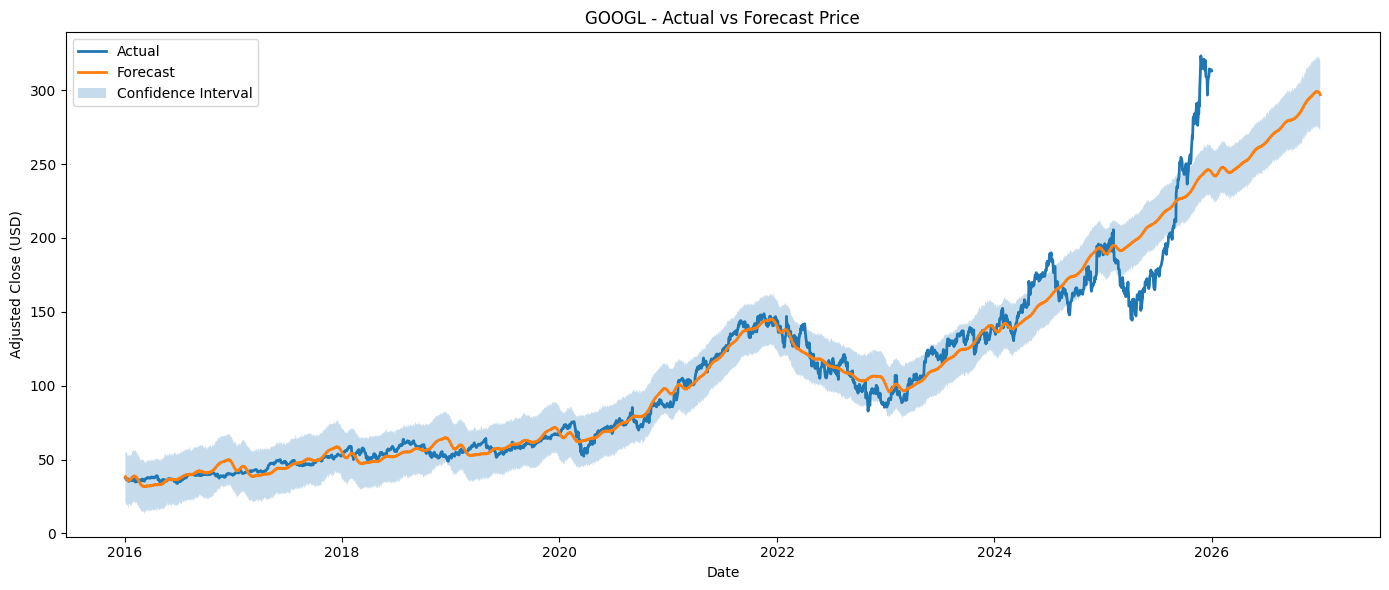

In [34]:
plt.figure(figsize=(14,6))
sns.lineplot(data=df_googl, x='ds', y='y', label='Actual', linewidth=2)
sns.lineplot(data=forecast_googl, x='ds', y='yhat', label='Forecast', linewidth=2)
plt.fill_between(
    forecast_googl['ds'],
    forecast_googl['yhat_lower'],
    forecast_googl['yhat_upper'],
    alpha=0.25,
    label='Confidence Interval'
)
plt.title("GOOGL - Actual vs Forecast Price")
plt.xlabel("Date")
plt.ylabel("Adjusted Close (USD)")
plt.legend()
plt.tight_layout()
plt.show()

##### Plotting the Trend Component

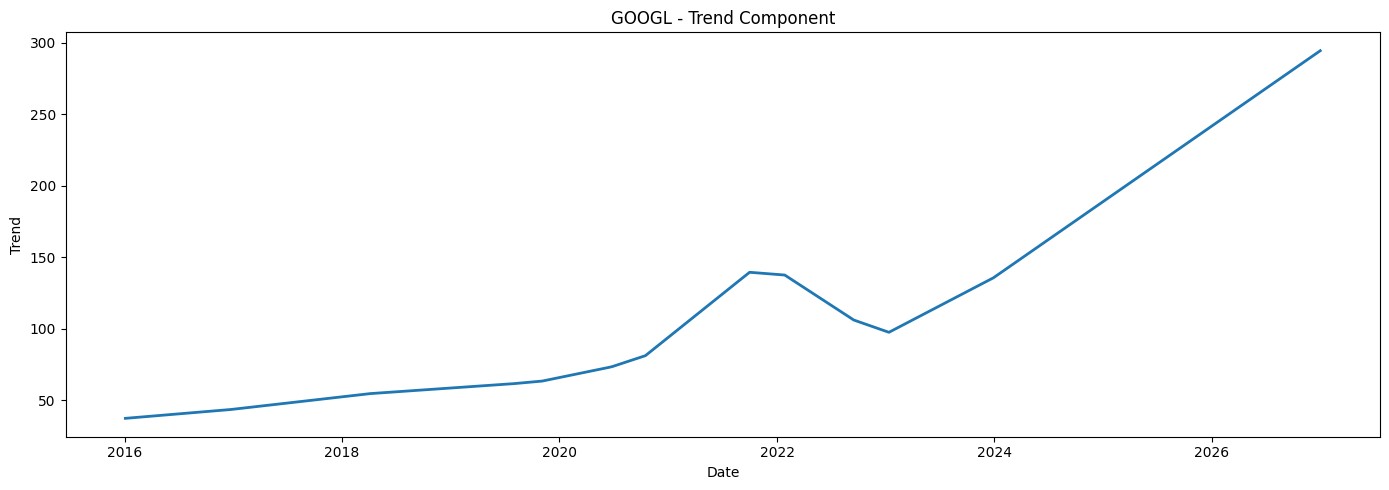

In [35]:
plt.figure(figsize=(14,5))
sns.lineplot(data=forecast_googl, x='ds', y='trend', linewidth=2)
plt.title("GOOGL - Trend Component")
plt.xlabel("Date")
plt.ylabel("Trend")
plt.tight_layout()
plt.show()

##### Plotting Yearly Seasonality

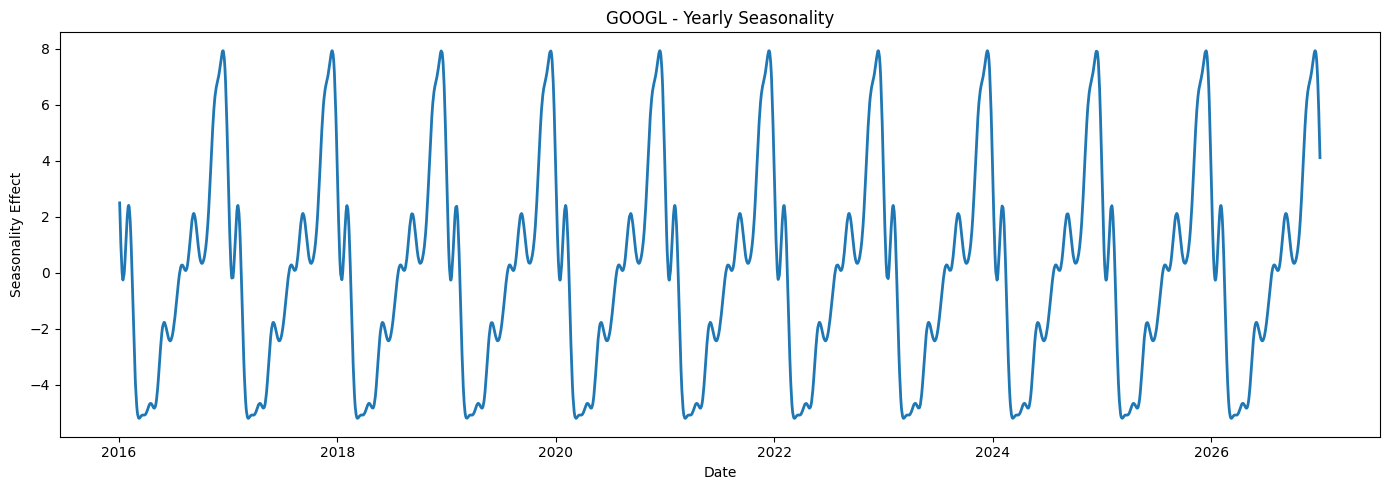

In [36]:
plt.figure(figsize=(14,5))
sns.lineplot(data=forecast_googl, x='ds', y='yearly', linewidth=2)
plt.title("GOOGL - Yearly Seasonality")
plt.xlabel("Date")
plt.ylabel("Seasonality Effect")
plt.tight_layout()
plt.show()

##### Plotting Monthly Component

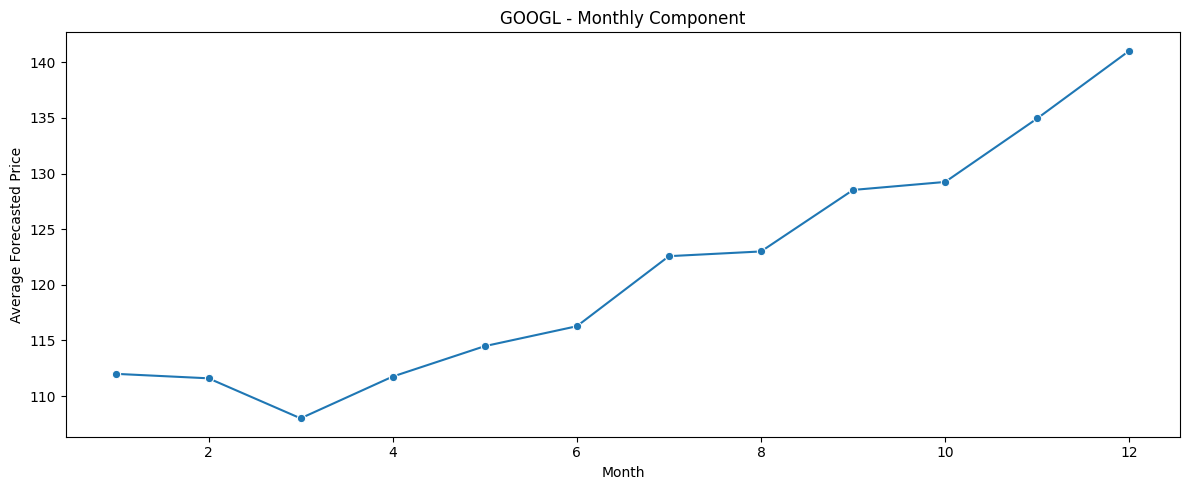

In [37]:
forecast_googl['month'] = forecast_googl['ds'].dt.month
monthly_googl = forecast_googl.groupby('month')['yhat'].mean().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_googl, x='month', y='yhat', marker='o')
plt.title("GOOGL - Monthly Component")
plt.xlabel("Month")
plt.ylabel("Average Forecasted Price")
plt.tight_layout()
plt.show()

##### Plotting Weekly Component

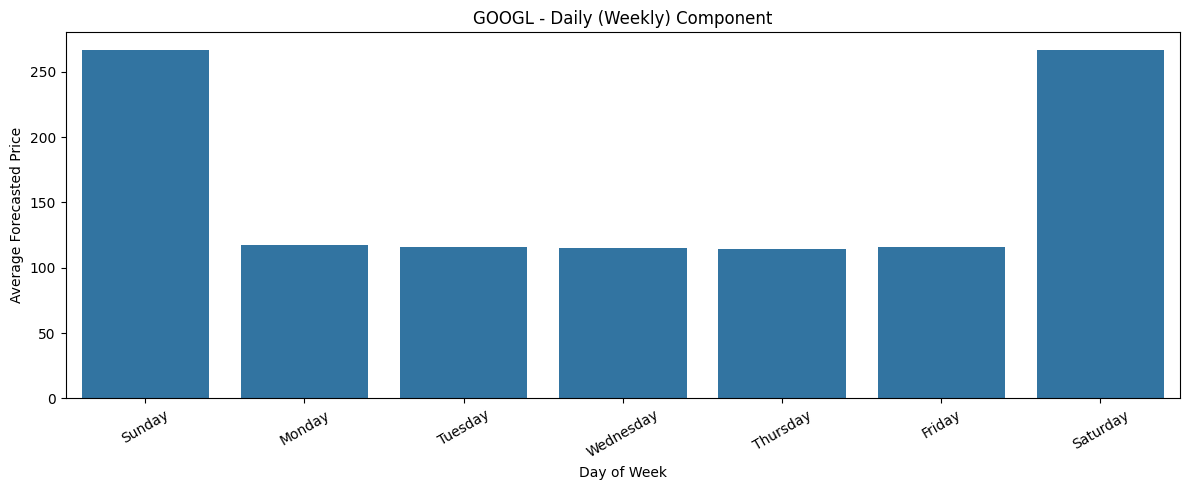

In [38]:
forecast_googl['weekday'] = forecast_googl['ds'].dt.day_name()
weekly_googl = forecast_googl.groupby('weekday')['yhat'].mean().reindex(weekly_order).reset_index()

plt.figure(figsize=(12,5))
sns.barplot(data=weekly_googl, x='weekday', y='yhat')
plt.title("GOOGL - Daily (Weekly) Component")
plt.xlabel("Day of Week")
plt.ylabel("Average Forecasted Price")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

##### Comparison of Components in Stocks

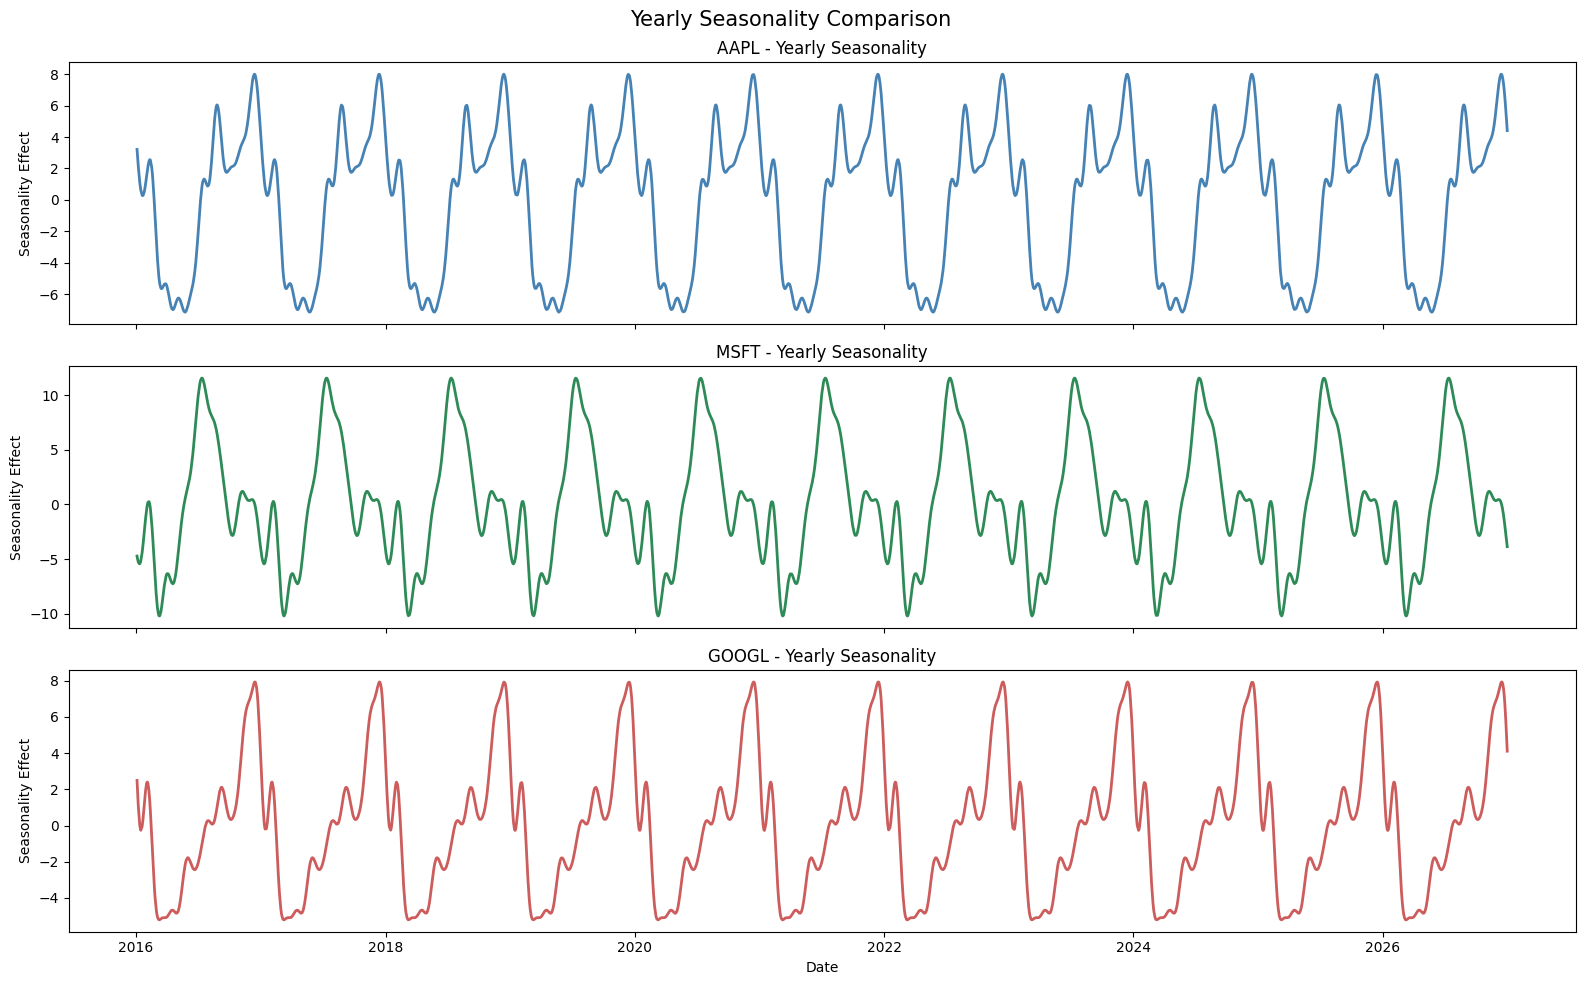

In [39]:
fig, axes = plt.subplots(3, 1, figsize=(16,10), sharex=True)

# AAPL
sns.lineplot(
    ax=axes[0],
    data=forecast_aapl,
    x='ds',
    y='yearly',
    color='steelblue',
    linewidth=2
)
axes[0].set_title("AAPL - Yearly Seasonality")
axes[0].set_ylabel("Seasonality Effect")

# MSFT
sns.lineplot(
    ax=axes[1],
    data=forecast_msft,
    x='ds',
    y='yearly',
    color='seagreen',
    linewidth=2
)
axes[1].set_title("MSFT - Yearly Seasonality")
axes[1].set_ylabel("Seasonality Effect")

# GOOGL
sns.lineplot(
    ax=axes[2],
    data=forecast_googl,
    x='ds',
    y='yearly',
    color='indianred',
    linewidth=2
)
axes[2].set_title("GOOGL - Yearly Seasonality")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Seasonality Effect")

plt.suptitle("Yearly Seasonality Comparison", fontsize=15)
plt.tight_layout()
plt.show()

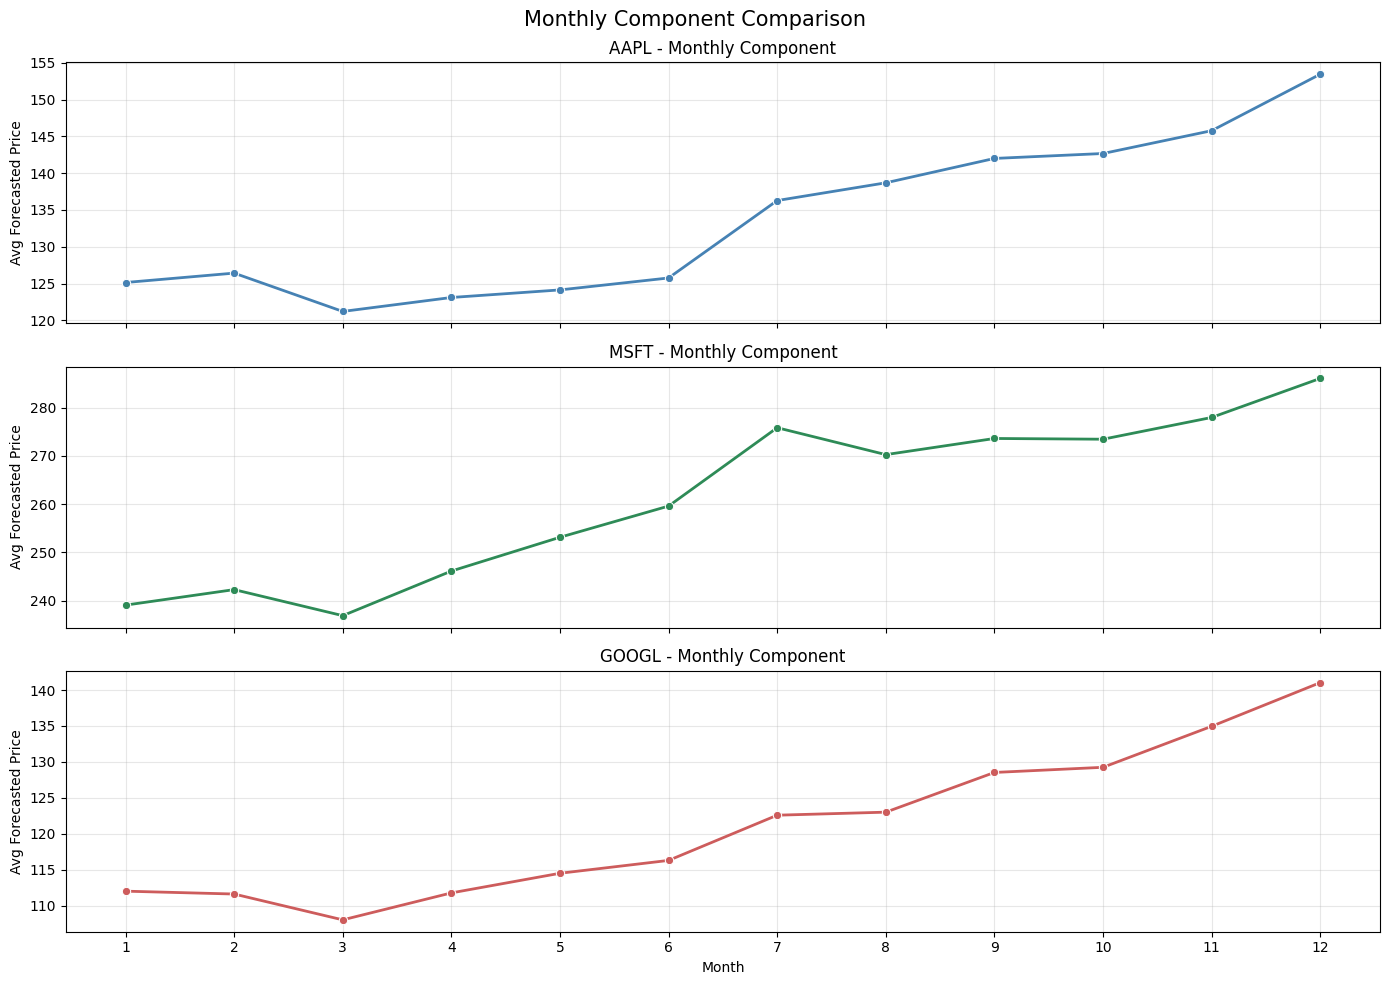

In [40]:
# Monthly Component

fig, axes = plt.subplots(3, 1, figsize=(14,10), sharex=True)

# AAPL
sns.lineplot(
    ax=axes[0],
    data=monthly_aapl,
    x='month',
    y='yhat',
    marker='o',
    linewidth=2,
    color='steelblue'
)
axes[0].set_title("AAPL - Monthly Component")
axes[0].set_ylabel("Avg Forecasted Price")

# MSFT
sns.lineplot(
    ax=axes[1],
    data=monthly_msft,
    x='month',
    y='yhat',
    marker='o',
    linewidth=2,
    color='seagreen'
)
axes[1].set_title("MSFT - Monthly Component")
axes[1].set_ylabel("Avg Forecasted Price")

# GOOGL
sns.lineplot(
    ax=axes[2],
    data=monthly_googl,
    x='month',
    y='yhat',
    marker='o',
    linewidth=2,
    color='indianred'
)
axes[2].set_title("GOOGL - Monthly Component")
axes[2].set_xlabel("Month")
axes[2].set_ylabel("Avg Forecasted Price")

# Formatting
for ax in axes:
    ax.set_xticks(range(1, 13))
    ax.grid(alpha=0.3)

plt.suptitle("Monthly Component Comparison", fontsize=15)
plt.tight_layout()
plt.show()

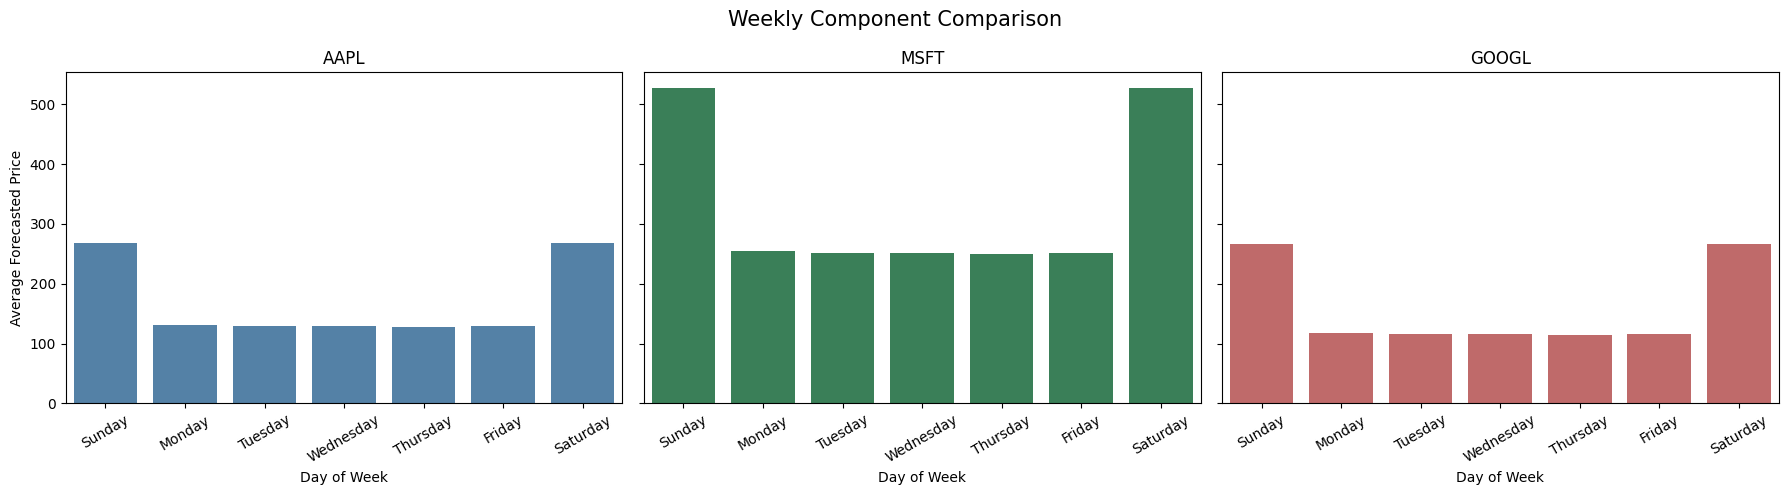

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

sns.barplot(ax=axes[0], data=weekly_aapl, x='weekday', y='yhat', color='steelblue')
axes[0].set_title("AAPL")

sns.barplot(ax=axes[1], data=weekly_msft, x='weekday', y='yhat', color='seagreen')
axes[1].set_title("MSFT")

sns.barplot(ax=axes[2], data=weekly_googl, x='weekday', y='yhat', color='indianred')
axes[2].set_title("GOOGL")

for ax in axes:
    ax.set_xlabel("Day of Week")
    ax.set_ylabel("Average Forecasted Price")
    ax.tick_params(axis='x', rotation=30)

plt.suptitle("Weekly Component Comparison", fontsize=15)
plt.tight_layout()
plt.show()